In [ ]:
from google.colab import files

# Upload kaggle.json manually
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishikabanka","key":"d9f1b9861fd51640be8cefd6d7a2979d"}'}

In [ ]:
import os

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle API (if not installed)
!pip install -q kaggle

In [ ]:
# Download dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

# Extract dataset
!unzip -q deepfake-and-real-images.zip -d deepfake_img

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_output_path = '/content/drive/MyDrive/Preprocessed_Deepfake'


Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from PIL import Image

# Set target dimension to 256x256 for compatibility with common models
dimension = (256, 256)

# Define dataset paths
dataset_path = 'deepfake_img/Dataset'
original_train_dir = os.path.join(dataset_path, 'Train')
original_val_dir = os.path.join(dataset_path, 'Validation')
original_test_dir = os.path.join(dataset_path, 'Test')

# Load ESRGAN model from TensorFlow Hub
esrgan_path = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(esrgan_path)

def preprocessing(img):
    """Prepare images for ESRGAN model input"""
    if img.shape[0] < 4 or img.shape[1] < 4:
        raise ValueError("Image dimensions must be at least 4x4 pixels.")

    # Calculate valid crop size divisible by 4
    image_size = (tf.convert_to_tensor(img.shape[:-1]) // 4) * 4
    cropped_image = tf.image.crop_to_bounding_box(
        img, 0, 0, image_size[0], image_size[1])

    # Normalize to [0, 1] range expected by ESRGAN
    preprocessed_image = tf.cast(cropped_image, tf.float32) / 255.0
    return tf.expand_dims(preprocessed_image, 0)

def srmodel(img):
    """Enhance image using ESRGAN model"""
    preprocessed_image = preprocessing(img)
    new_image = model(preprocessed_image)
    return tf.squeeze(new_image)

# Set up preprocessing directories
preprocessed_base = '/content/drive/MyDrive/Preprocessed_Deepfake'
preprocessed_train_dir = os.path.join(preprocessed_base, 'Train')
preprocessed_val_dir = os.path.join(preprocessed_base, 'Validation')
preprocessed_test_dir = os.path.join(preprocessed_base, 'Test')

# Create directory structure
os.makedirs(preprocessed_train_dir, exist_ok=True)
os.makedirs(preprocessed_val_dir, exist_ok=True)
os.makedirs(preprocessed_test_dir, exist_ok=True)

for class_name in ['Fake', 'Real']:
    for dir_path in [preprocessed_train_dir, preprocessed_val_dir, preprocessed_test_dir]:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# Initialize face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_save_faces(original_dir, preprocessed_dir):
    """Process images through face detection and enhancement pipeline"""
    counter = 0
    processed_count = 0

    for class_name in ['Fake', 'Real']:
        class_path = os.path.join(original_dir, class_name)
        preprocessed_class_path = os.path.join(preprocessed_dir, class_name)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)

            if img is None:
                #print(f"Warning: Could not read image {image_path}")
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

            if len(faces) == 0:
              #print(f"No faces detected in {image_path}")
                continue

            # Process largest face
            x, y, w, h = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
            face = img[y:y+h, x:x+w]
            face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            output_path = os.path.join(preprocessed_class_path, image_name)
            #print(f"faces detected in {image_path}")

            try:
                if w >= 256 and h >= 256:
                    # Directly resize large enough faces
                    resized_face = cv2.resize(face_rgb, dimension, interpolation=cv2.INTER_AREA)
                else:
                    # Enhance small faces with super-resolution
                    face_tensor = tf.convert_to_tensor(face_rgb, dtype=tf.float32)
                    sr_face = srmodel(face_tensor)
                    sr_face = (sr_face.numpy() * 255).astype(np.uint8)
                    resized_face = cv2.resize(sr_face, dimension, interpolation=cv2.INTER_CUBIC)

                # Save processed image
                Image.fromarray(resized_face).save(output_path)
                processed_count += 1

                # Progress reporting
                if processed_count % 1000 == 0:
                    counter += 1
                    print(f"Processed {counter * 1000} images")

            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")

# Execute preprocessing pipeline
print("Preprocessing training data...")
detect_and_save_faces(original_train_dir, preprocessed_train_dir)

print("\nPreprocessing validation data...")
detect_and_save_faces(original_val_dir, preprocessed_val_dir)

print("\nPreprocessing test data...")
detect_and_save_faces(original_test_dir, preprocessed_test_dir)

print("\nPreprocessing complete!")

Preprocessing training data...
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processed 18000 images
Processed 19000 images
Processed 20000 images
Processed 21000 images
Processed 22000 images
Processed 23000 images
Processed 24000 images
Processed 25000 images
Processed 26000 images
Processed 27000 images
Processed 28000 images
Processed 29000 images
Processed 30000 images
Processed 31000 images
Processed 32000 images
Processed 33000 images
Processed 34000 images
Processed 35000 images
Processed 36000 images
Processed 37000 images
Processed 38000 images
Processed 39000 images
Processed 40000 images
Processed 41000 images
Processed 42000 images
Processed 43

Running on CPU/GPU
Found 121514 images belonging to 2 classes.
Found 33886 images belonging to 2 classes.
Found 9026 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8796 - auc: 0.9448 - loss: 0.2822
Epoch 1: val_accuracy improved from -inf to 0.88346, saving model to 140K_resnet50_model.keras
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 4018s 2s/step - accuracy: 0.8796 - auc: 0.9448 - loss: 0.2822 - val_accuracy: 0.8835 - val_auc: 0.9585 - val_loss: 0.2707 - learning_rate: 1.0000e-04
Epoch 2/10
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9518 - auc: 0.9896 - loss: 0.1262
Epoch 2: val_accuracy improved from 0.88346 to 0.93602, saving model to 140K_resnet50_model.keras
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 3494s 2s/step - accuracy: 0.9518 - auc: 0.9896 - loss: 0.1262 - val_accuracy: 0.9360 - val_auc: 0.9839 - val_loss: 0.1618 - learning_rate: 1.0000e-04
Epoch 3/10
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9611 - auc: 0.9925 - loss: 0.1049
Epoch 3: val_accuracy did not improve from 0.93602
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 3440s 2s/step - accuracy: 0.9611 - auc: 0.9925 - loss: 0.104

Test accuracy: 0.9133


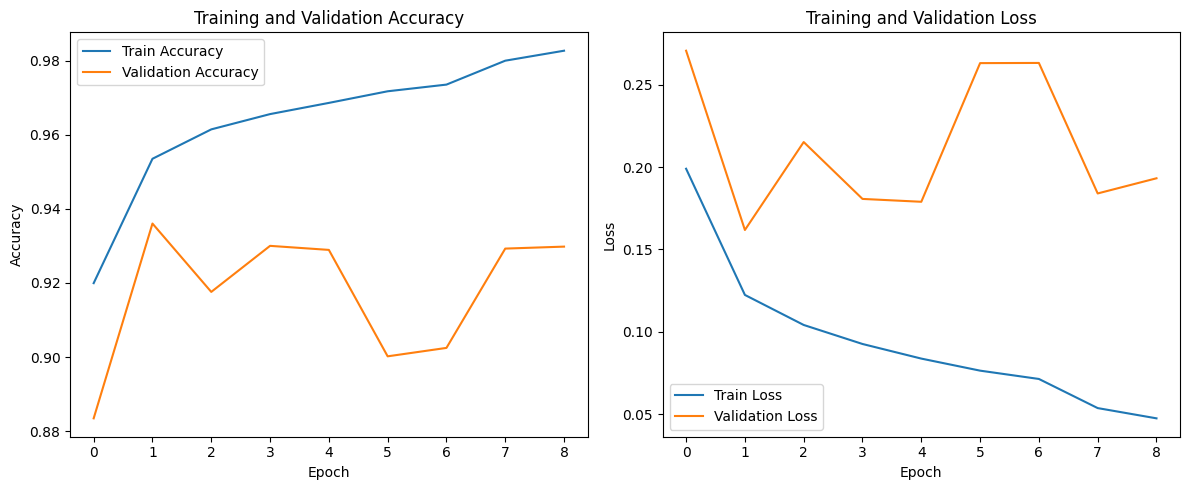

142/142 ━━━━━━━━━━━━━━━━━━━━ 58s 377ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      4486
           1       0.78      0.90      0.84      4540

    accuracy                           0.82      9026
   macro avg       0.83      0.82      0.82      9026
weighted avg       0.83      0.82      0.82      9026

Confusion Matrix:
[[3333 1153]
 [ 455 4085]]


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Enable TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU/GPU")

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define dataset paths
dataset_path = '/content/drive/MyDrive/Preprocessed_Deepfake'
train_dir = os.path.join(dataset_path, 'Train')
val_dir = os.path.join(dataset_path, 'Validation')
test_dir = os.path.join(dataset_path, 'Test')

# Hyperparameters
img_size = (255, 255)
batch_size = 64
epochs = 10  # Increased to allow early stopping to work effectively
learning_rate = 0.0001

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    #target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    #target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    #target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Load Xception without the top layer
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    # Add custom layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0,3)(x)
    x = Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dense(2, activation='sigmoid')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=["accuracy", AUC(name='auc')])

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.5,  # Minimum accuracy improvement threshold (0.5%)
    patience=8,       # Wait for 7 epochs before stopping
    verbose=1,
    mode='max',
    restore_best_weights=True
)
#after the 5th ephoch we use this to reduce learning rate to get more stable results
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
checkpoint_path = '140K_resnet50_model.keras'

#we use model checkpoint to save best weights and we make that when the validation_accuracy increase
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


# Training with enhanced callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,

    callbacks=[early_stopping, reduce_lr , model_checkpoint],
    verbose=1
)

# Evaluation
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=0)
print(f'Test accuracy: {test_auc:.4f}')

# Save model
model.save("deepfake_model_ResNet50.h5")
model.save("deepfake_model_ResNet50.keras")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Performance metrics
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print('Classification Report:')
print(classification_report(y_true, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

In [ ]:
/content/drive/MyDrive/